In [3]:
import matplotlib.pyplot as plt
import numpy as np

Here, we expand on the Monte Carlo simulation in airfare_dynamics_intro.ipynb to better reflect real-life scenarios. Each fare bucket has a base demand curve based on the days until the flight departs. From this base demand curve, we construct exponential demand functions for each of the fare buckets, with more price sensitivity for the cheaper-fare tickets, based on the prices for each of those tickets. Additionally, the prices for each of the fare buckets move dynamically as more or less tickets sell each day than expected. Demand for each ticket then moves accordingly.

In [113]:
# Different base demand curve functions:

def linear(a, b, x):
    return a + b * x

def convex(a, b, c, x):
    return a + b * (x ** c)

def bell(a, mu, sigma, x):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

We perform this analysis by assuming a Gaussian base demand for each ticket type. We make the assumption that demand for the cheaper fare buckets spike a long time before the departure date, while demand for the more expensive tickets spike closer to the departure date. 

In [242]:
# Parameters
days_to_departure = 30
num_customers_per_day = 100
num_trials = 1000
alpha = 0.005  # price adjustment sensitivity

#Fare Bucket Setup
base_fare_buckets = [
    {
        "label": "Economy Basic",
        "base_price": 200,
        "capacity": 40,
        "elasticity": 0.025,
        "base_demand_curve": [bell(300, 8, 10, day) for day in range(days_to_departure)]  # Demand curve function
    },
    {
        "label": "Economy Flex",
        "base_price": 250,
        "capacity": 30,
        "elasticity": 0.015,
        "base_demand_curve": [bell(200, 15, 10, day) for day in range(days_to_departure)] # Demand curve function
    },
    {
        "label": "Premium",
        "base_price": 400,
        "capacity": 20,
        "elasticity": 0.01,
        "base_demand_curve": [bell(100, 20, 5, day) for day in range(days_to_departure)]
    },
    {
        "label": "Business",
        "base_price": 800,
        "capacity": 10,
        "elasticity": 0.005,
        "base_demand_curve": [bell(10, 25, 2, day) for day in range(days_to_departure)]  # Demand curve function
    }
]

bucket_labels = [b["label"] for b in base_fare_buckets]
num_buckets = len(base_fare_buckets)

# --- Trackers ---
total_revenues = []
fare_sales_all_trials = [[] for _ in base_fare_buckets]
fare_revenues_all_trials = [[] for _ in base_fare_buckets]
seats_sold_per_day = [[0 for _ in range(days_to_departure)] for _ in range(len(base_fare_buckets))]
price_paths_example_trial = [[] for _ in base_fare_buckets]  # for 1st trial
demand_paths_example_trial = [[] for _ in base_fare_buckets]  # for 1st trial

# --- Demand Function ---
def purchase_probability(demand, price, elasticity, capacity):
    demand_at_price = demand * np.exp(-elasticity * price)
    return min(1.0, demand_at_price / capacity)

# --- Price Adjustment ---
def adjust_price(bucket, actual, expected):
    if expected == 0:
        return
    pressure = actual / expected
    if pressure > 1.05:
        bucket["price"] *= 1 + alpha * np.log(pressure)
        bucket["price_increases"] += 1
    elif pressure < 0.75:
        bucket["price"] = max(bucket["base_price"], bucket["price"] * (1 - alpha * (1 - np.log(pressure))))

# --- Single Simulation ---
def run_simulation(track_prices=False):
    fare_buckets = []
    for b in base_fare_buckets:
        fare_buckets.append({
            **b,
            "sold": 0,
            "revenue": 0,
            "price": b["base_price"],
            "price_increases": 0
        })

    if track_prices:
        local_price_paths = [[] for _ in base_fare_buckets]
        local_demand_paths = [[] for _ in base_fare_buckets]
        for i, bucket in enumerate(fare_buckets):
            local_price_paths[i].append(bucket["price"])
            local_demand_paths[i].append(bucket["base_demand_curve"][0]) 


    for day in range(days_to_departure):
        for i, bucket in enumerate(fare_buckets):
            # Calculate base demand for this day
            base_demand_today = bucket["base_demand_curve"][day]

            if bucket["sold"] >= bucket["capacity"]:
                if track_prices:
                    # Calculate demand using exponential function based on price and elasticity
                    demand = base_demand_today * np.exp(-bucket["elasticity"] * bucket["price"])
                    local_price_paths[i].append(bucket["price"])
                    local_demand_paths[i].append(demand)
                continue

            total_sold_today = 0
            # Calculate base demand for this day
            base_demand_today = bucket["base_demand_curve"][day]

            for _ in range(num_customers_per_day):

                if bucket["sold"] >= bucket["capacity"]:
                    break

                # Calculate purchase probability using base demand, price, elasticity, and capacity
                prob = purchase_probability(base_demand_today, bucket["price"], bucket["elasticity"], bucket["capacity"])

                expected_sold = num_customers_per_day * prob

                if np.random.rand() < prob:
                    bucket["sold"] += 1
                    total_sold_today += 1
                    bucket["revenue"] += bucket["price"]
                    
            # Adjust price based on actual vs expected fill on the day
            adjust_price(bucket, total_sold_today, expected_sold)

            if track_prices:
                # Calculate demand using exponential function based on price and elasticity
                demand = base_demand_today * np.exp(-bucket["elasticity"] * bucket["price"])
                local_price_paths[i].append(bucket["price"])
                local_demand_paths[i].append(demand)

    # Save outputs
    total_revenue = sum(b["revenue"] for b in fare_buckets)
    total_revenues.append(total_revenue)

    for i, b in enumerate(fare_buckets):
        fare_sales_all_trials[i].append(b["sold"])
        fare_revenues_all_trials[i].append(b["revenue"])

    if track_prices:
        for i in range(num_buckets):
            price_paths_example_trial[i] = local_price_paths[i]
            demand_paths_example_trial[i] = local_demand_paths[i]

In [243]:
# --- Run Monte Carlo ---
for t in range(num_trials):
    run_simulation(track_prices=(t == 0))  # only track price path for 1st trial

# --- Summary Statistics ---
mean_revenue = np.mean(total_revenues)
median_revenue = np.median(total_revenues)
std_revenue = np.std(total_revenues)

print("=== Revenue Summary ===")
print(f"Mean Revenue: ${mean_revenue:.2f}")
print(f"Median Revenue: ${median_revenue:.2f}")
print(f"Std Dev Revenue: ${std_revenue:.2f}\n")

print("=== Fare Bucket Summary ===")
for i, label in enumerate(bucket_labels):
    mean_sold = np.mean(fare_sales_all_trials[i])
    mean_rev = np.mean(fare_revenues_all_trials[i])
    print(f"{label}: Avg Tickets Sold = {mean_sold:.2f}, Avg Revenue = ${mean_rev:.2f}")

/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_15201/866874184.py:64: RuntimeWarning: divide by zero encountered in log
  bucket["price"] = max(bucket["base_price"], bucket["price"] * (1 - alpha * (1 - np.log(pressure))))


=== Revenue Summary ===
Mean Revenue: $30088.01
Median Revenue: $30722.97
Std Dev Revenue: $1563.84

=== Fare Bucket Summary ===
Economy Basic: Avg Tickets Sold = 40.00, Avg Revenue = $8010.94
Economy Flex: Avg Tickets Sold = 30.00, Avg Revenue = $7505.79
Premium: Avg Tickets Sold = 20.00, Avg Revenue = $8017.06
Business: Avg Tickets Sold = 8.18, Avg Revenue = $6554.21


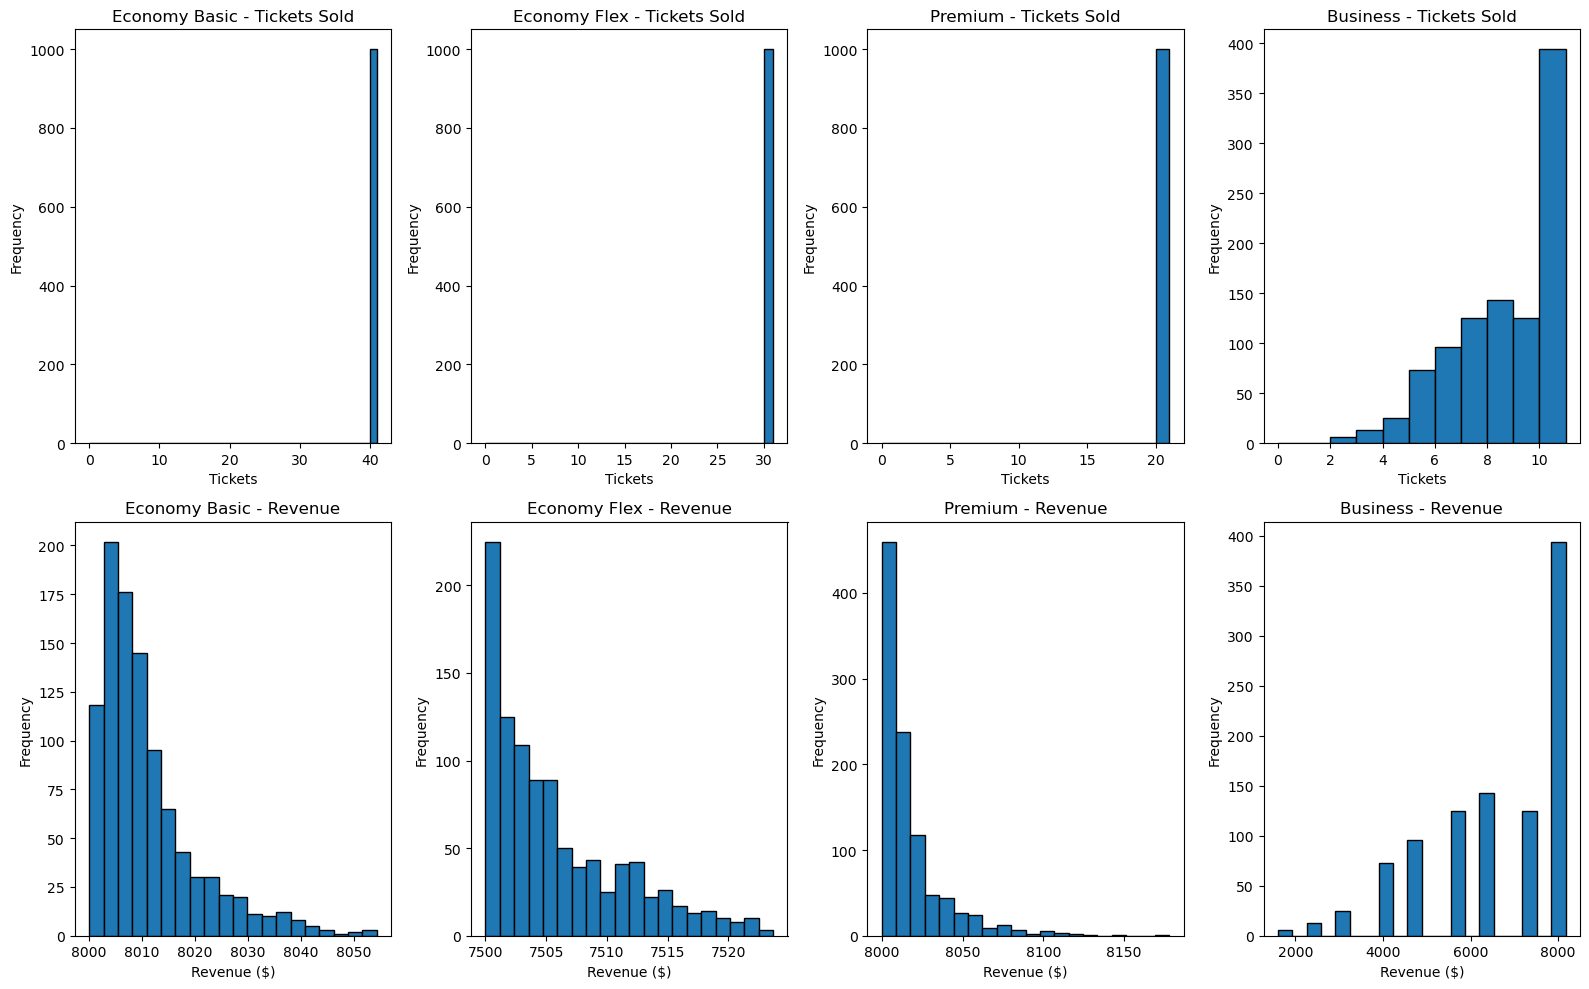

In [244]:
# --- Plot Histograms of Fare Bucket Revenues and Tickets Sold ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].hist(fare_sales_all_trials[i], bins=range(0, base_fare_buckets[i]["capacity"] + 2), edgecolor='black')
    axs[0, i].set_title(f"{label} - Tickets Sold")
    axs[0, i].set_xlabel("Tickets")
    axs[0, i].set_ylabel("Frequency")

    axs[1, i].hist(fare_revenues_all_trials[i], bins=20, edgecolor='black')
    axs[1, i].set_title(f"{label} - Revenue")
    axs[1, i].set_xlabel("Revenue ($)")
    axs[1, i].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("fare_bucket_histograms_1.png")
plt.show()

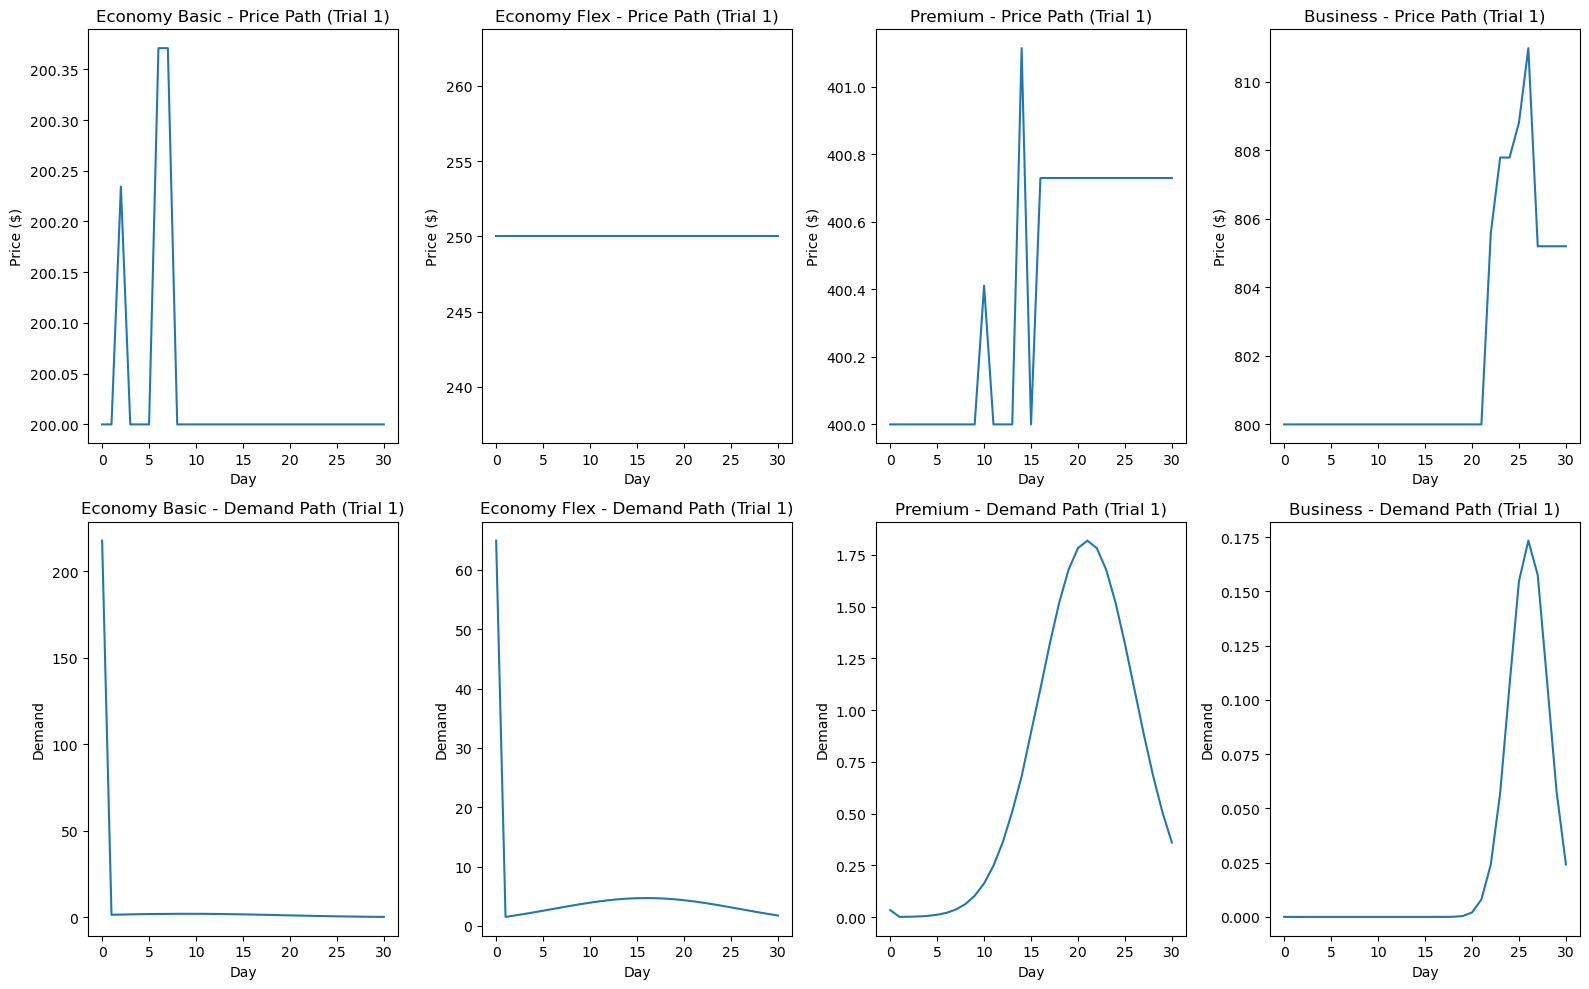

In [245]:
# --- Plot Price and Demand Paths for 1st Trial ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].plot(price_paths_example_trial[i])
    axs[0, i].set_title(f"{label} - Price Path (Trial 1)")
    axs[0, i].set_xlabel("Day")
    axs[0, i].set_ylabel("Price ($)")

    axs[1, i].plot(demand_paths_example_trial[i])
    axs[1, i].set_title(f"{label} - Demand Path (Trial 1)")
    axs[1, i].set_xlabel("Day")
    axs[1, i].set_ylabel("Demand")
plt.tight_layout()
plt.savefig("price_demand_paths_1.png")
plt.show()

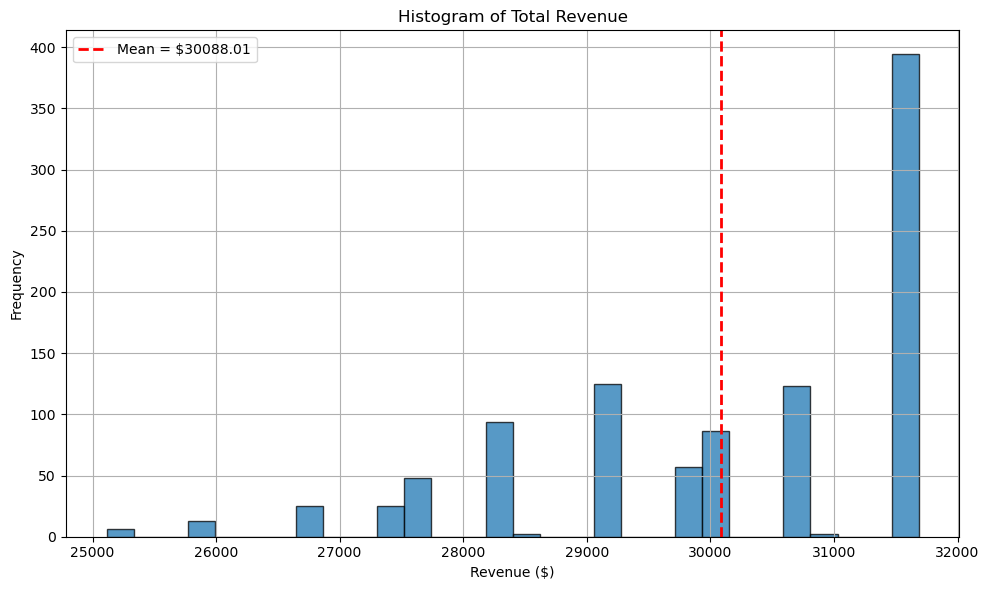

In [246]:
# Plotting revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(total_revenues, bins=30, edgecolor='black', alpha=0.75)
plt.axvline(mean_revenue, color='red', linestyle='dashed', linewidth=2, label=f"Mean = ${mean_revenue:.2f}")

plt.title("Histogram of Total Revenue")
plt.xlabel("Revenue ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("revenue_histogram_1.png")
plt.show()

From the experiment above, we can see that the lower priced tickets are selling out. First, we will try increasing the initial prices for the lower three fare buckets.

In [247]:
# Fare Bucket Setup
base_fare_buckets = [
    {
        "label": "Economy Basic",
        "base_price": 250,
        "capacity": 40,
        "elasticity": 0.025,
        "base_demand_curve": [bell(300, 8, 10, day) for day in range(days_to_departure)]  # Demand curve function
    },
    {
        "label": "Economy Flex",
        "base_price": 400,
        "capacity": 30,
        "elasticity": 0.015,
        "base_demand_curve": [bell(200, 15, 10, day) for day in range(days_to_departure)] # Demand curve function
    },
    {
        "label": "Premium",
        "base_price": 600,
        "capacity": 20,
        "elasticity": 0.01,
        "base_demand_curve": [bell(100, 20, 5, day) for day in range(days_to_departure)]
    },
    {
        "label": "Business",
        "base_price": 800,
        "capacity": 10,
        "elasticity": 0.005,
        "base_demand_curve": [bell(10, 25, 2, day) for day in range(days_to_departure)]  # Demand curve function
    }
]

bucket_labels = [b["label"] for b in base_fare_buckets]
num_buckets = len(base_fare_buckets)

# --- Trackers ---
total_revenues = []
fare_sales_all_trials = [[] for _ in base_fare_buckets]
fare_revenues_all_trials = [[] for _ in base_fare_buckets]
price_paths_example_trial = [[] for _ in base_fare_buckets]  # for 1st trial
demand_paths_example_trial = [[] for _ in base_fare_buckets]


In [248]:
# --- Run Monte Carlo ---
for t in range(num_trials):
    run_simulation(track_prices=(t == 0))  # only track price path for 1st trial

# --- Summary Statistics ---
mean_revenue = np.mean(total_revenues)
median_revenue = np.median(total_revenues)
std_revenue = np.std(total_revenues)

print("=== Revenue Summary ===")
print(f"Mean Revenue: ${mean_revenue:.2f}")
print(f"Median Revenue: ${median_revenue:.2f}")
print(f"Std Dev Revenue: ${std_revenue:.2f}\n")

print("=== Fare Bucket Summary ===")
for i, label in enumerate(bucket_labels):
    mean_sold = np.mean(fare_sales_all_trials[i])
    mean_rev = np.mean(fare_revenues_all_trials[i])
    print(f"{label}: Avg Tickets Sold = {mean_sold:.2f}, Avg Revenue = ${mean_rev:.2f}")

/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_15201/866874184.py:64: RuntimeWarning: divide by zero encountered in log
  bucket["price"] = max(bucket["base_price"], bucket["price"] * (1 - alpha * (1 - np.log(pressure))))


=== Revenue Summary ===
Mean Revenue: $34207.63
Median Revenue: $34306.56
Std Dev Revenue: $2879.89

=== Fare Bucket Summary ===
Economy Basic: Avg Tickets Sold = 28.01, Avg Revenue = $7019.94
Economy Flex: Avg Tickets Sold = 29.48, Avg Revenue = $11817.56
Premium: Avg Tickets Sold = 14.42, Avg Revenue = $8676.15
Business: Avg Tickets Sold = 8.35, Avg Revenue = $6693.98


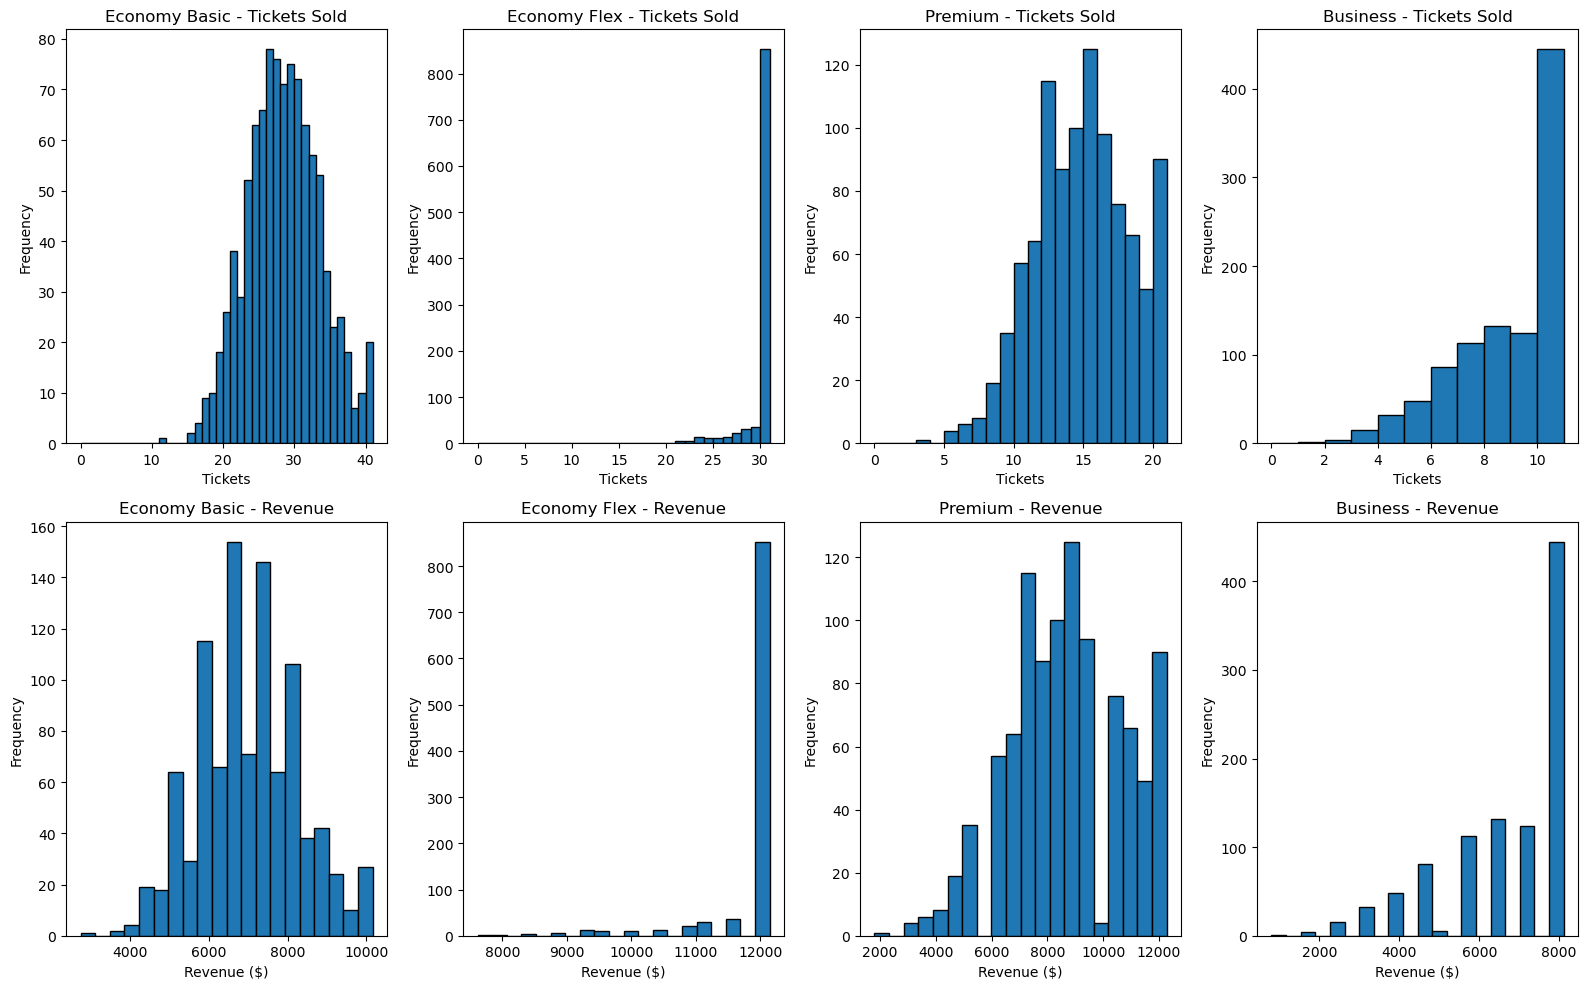

In [249]:
# --- Plot Histograms of Fare Bucket Revenues and Tickets Sold ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].hist(fare_sales_all_trials[i], bins=range(0, base_fare_buckets[i]["capacity"] + 2), edgecolor='black')
    axs[0, i].set_title(f"{label} - Tickets Sold")
    axs[0, i].set_xlabel("Tickets")
    axs[0, i].set_ylabel("Frequency")

    axs[1, i].hist(fare_revenues_all_trials[i], bins=20, edgecolor='black')
    axs[1, i].set_title(f"{label} - Revenue")
    axs[1, i].set_xlabel("Revenue ($)")
    axs[1, i].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("fare_bucket_histograms_2.png")
plt.show()

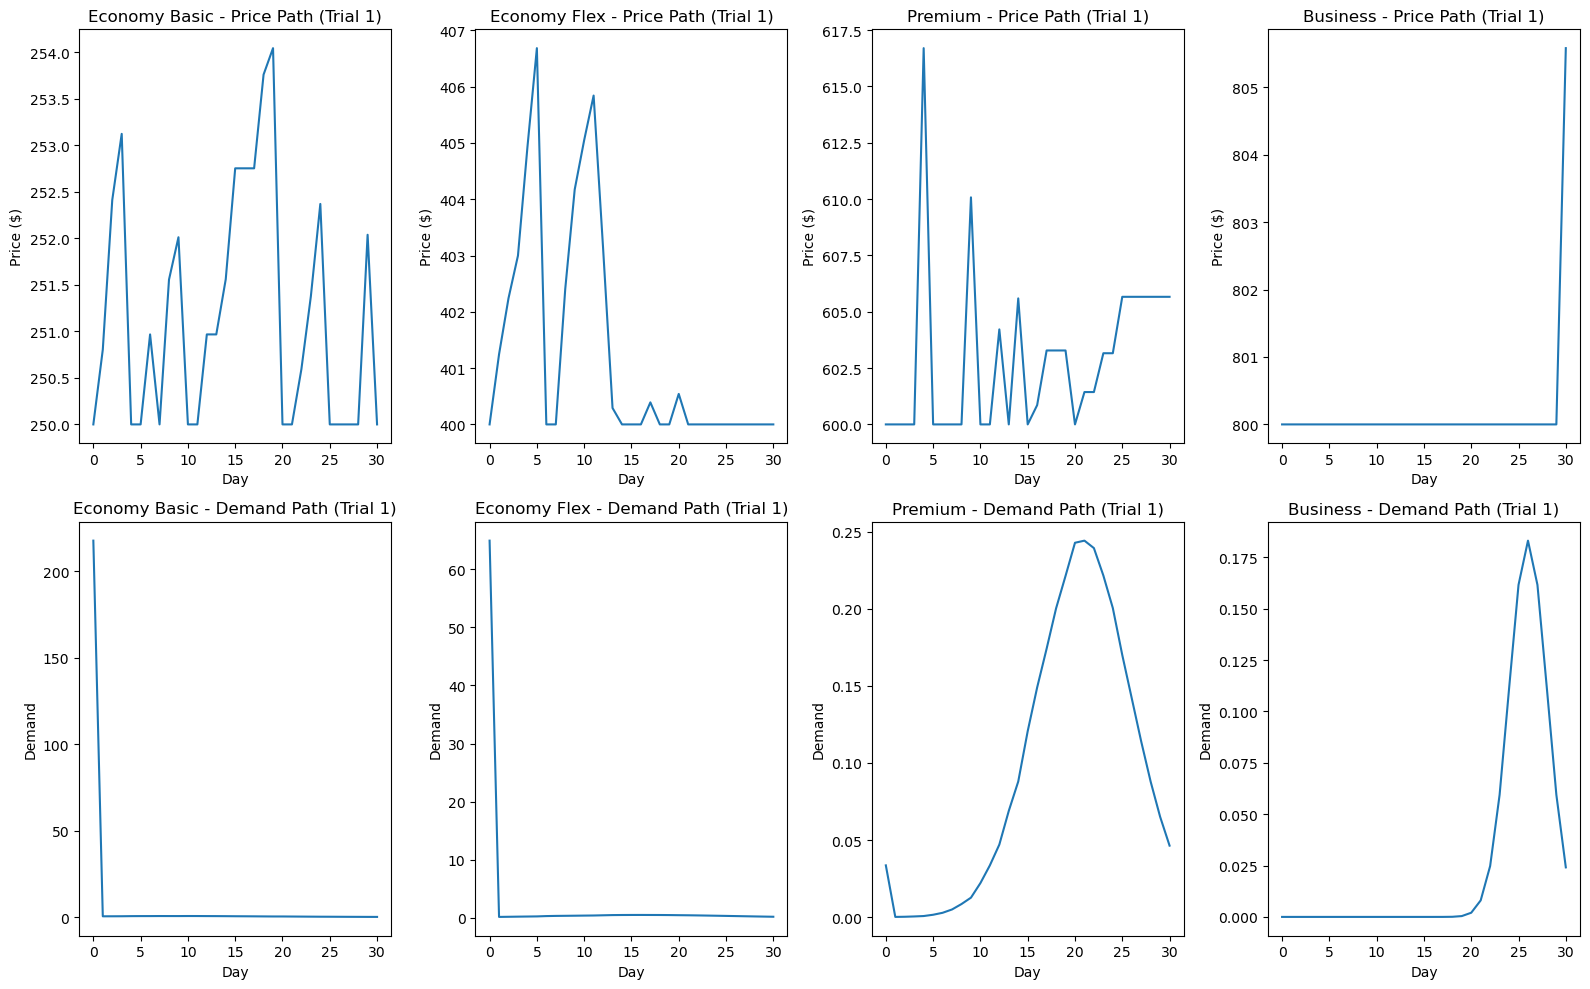

In [250]:
# --- Plot Price and Demand Paths for 1st Trial ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].plot(price_paths_example_trial[i])
    axs[0, i].set_title(f"{label} - Price Path (Trial 1)")
    axs[0, i].set_xlabel("Day")
    axs[0, i].set_ylabel("Price ($)")

    axs[1, i].plot(demand_paths_example_trial[i])
    axs[1, i].set_title(f"{label} - Demand Path (Trial 1)")
    axs[1, i].set_xlabel("Day")
    axs[1, i].set_ylabel("Demand")

plt.tight_layout()
plt.savefig("price_demand_paths_2.png")
plt.show()

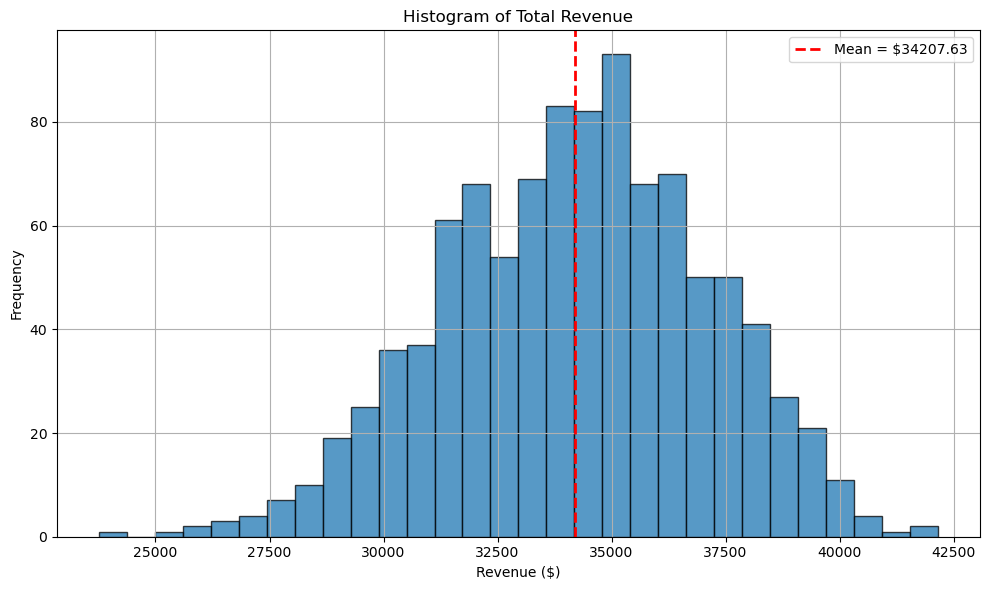

In [251]:
# Plotting revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(total_revenues, bins=30, edgecolor='black', alpha=0.75)
plt.axvline(mean_revenue, color='red', linestyle='dashed', linewidth=2, label=f"Mean = ${mean_revenue:.2f}")

plt.title("Histogram of Total Revenue")
plt.xlabel("Revenue ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("revenue_histogram_2.png")
plt.show()

Increasing the initial prices worked to prevent the lower fare buckets from selling out, and in turn increased total revenue. However, the price movements in the given algorithm are sharp. We will adjust the thresholds so that prices aren't as sensitive to movement.

In [256]:
# Fare Bucket Setup
base_fare_buckets = [
    {
        "label": "Economy Basic",
        "base_price": 250,
        "capacity": 40,
        "elasticity": 0.025,
        "base_demand_curve": [bell(300, 8, 10, day) for day in range(days_to_departure)]  # Demand curve function
    },
    {
        "label": "Economy Flex",
        "base_price": 400,
        "capacity": 30,
        "elasticity": 0.015,
        "base_demand_curve": [bell(200, 15, 10, day) for day in range(days_to_departure)] # Demand curve function
    },
    {
        "label": "Premium",
        "base_price": 600,
        "capacity": 20,
        "elasticity": 0.01,
        "base_demand_curve": [bell(100, 20, 5, day) for day in range(days_to_departure)]
    },
    {
        "label": "Business",
        "base_price": 800,
        "capacity": 10,
        "elasticity": 0.005,
        "base_demand_curve": [bell(10, 25, 2, day) for day in range(days_to_departure)]  # Demand curve function
    }
]

bucket_labels = [b["label"] for b in base_fare_buckets]
num_buckets = len(base_fare_buckets)

# --- Trackers ---
total_revenues = []
fare_sales_all_trials = [[] for _ in base_fare_buckets]
fare_revenues_all_trials = [[] for _ in base_fare_buckets]
price_paths_example_trial = [[] for _ in base_fare_buckets]  # for 1st trial
demand_paths_example_trial = [[] for _ in base_fare_buckets]

# --- Price Adjustment ---
def adjust_price(bucket, actual, expected):
    if expected == 0:
        return
    pressure = actual / expected
    if pressure > 1.1:
        bucket["price"] *= 1 + alpha * np.log(pressure)
        bucket["price_increases"] += 1
    elif pressure < 0.98:
        bucket["price"] = max(bucket["base_price"], bucket["price"] * (1 - alpha * (1 - np.log(pressure))))

In [257]:
# --- Run Monte Carlo ---
for t in range(num_trials):
    run_simulation(track_prices=(t == 0))  # only track price path for 1st trial

# --- Summary Statistics ---
mean_revenue = np.mean(total_revenues)
median_revenue = np.median(total_revenues)
std_revenue = np.std(total_revenues)

print("=== Revenue Summary ===")
print(f"Mean Revenue: ${mean_revenue:.2f}")
print(f"Median Revenue: ${median_revenue:.2f}")
print(f"Std Dev Revenue: ${std_revenue:.2f}\n")

print("=== Fare Bucket Summary ===")
for i, label in enumerate(bucket_labels):
    mean_sold = np.mean(fare_sales_all_trials[i])
    mean_rev = np.mean(fare_revenues_all_trials[i])
    print(f"{label}: Avg Tickets Sold = {mean_sold:.2f}, Avg Revenue = ${mean_rev:.2f}")

/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_15201/1190322460.py:52: RuntimeWarning: divide by zero encountered in log
  bucket["price"] = max(bucket["base_price"], bucket["price"] * (1 - alpha * (1 - np.log(pressure))))


=== Revenue Summary ===
Mean Revenue: $34485.68
Median Revenue: $34608.15
Std Dev Revenue: $2782.21

=== Fare Bucket Summary ===
Economy Basic: Avg Tickets Sold = 28.31, Avg Revenue = $7092.00
Economy Flex: Avg Tickets Sold = 29.59, Avg Revenue = $11858.39
Premium: Avg Tickets Sold = 14.71, Avg Revenue = $8844.33
Business: Avg Tickets Sold = 8.35, Avg Revenue = $6690.96


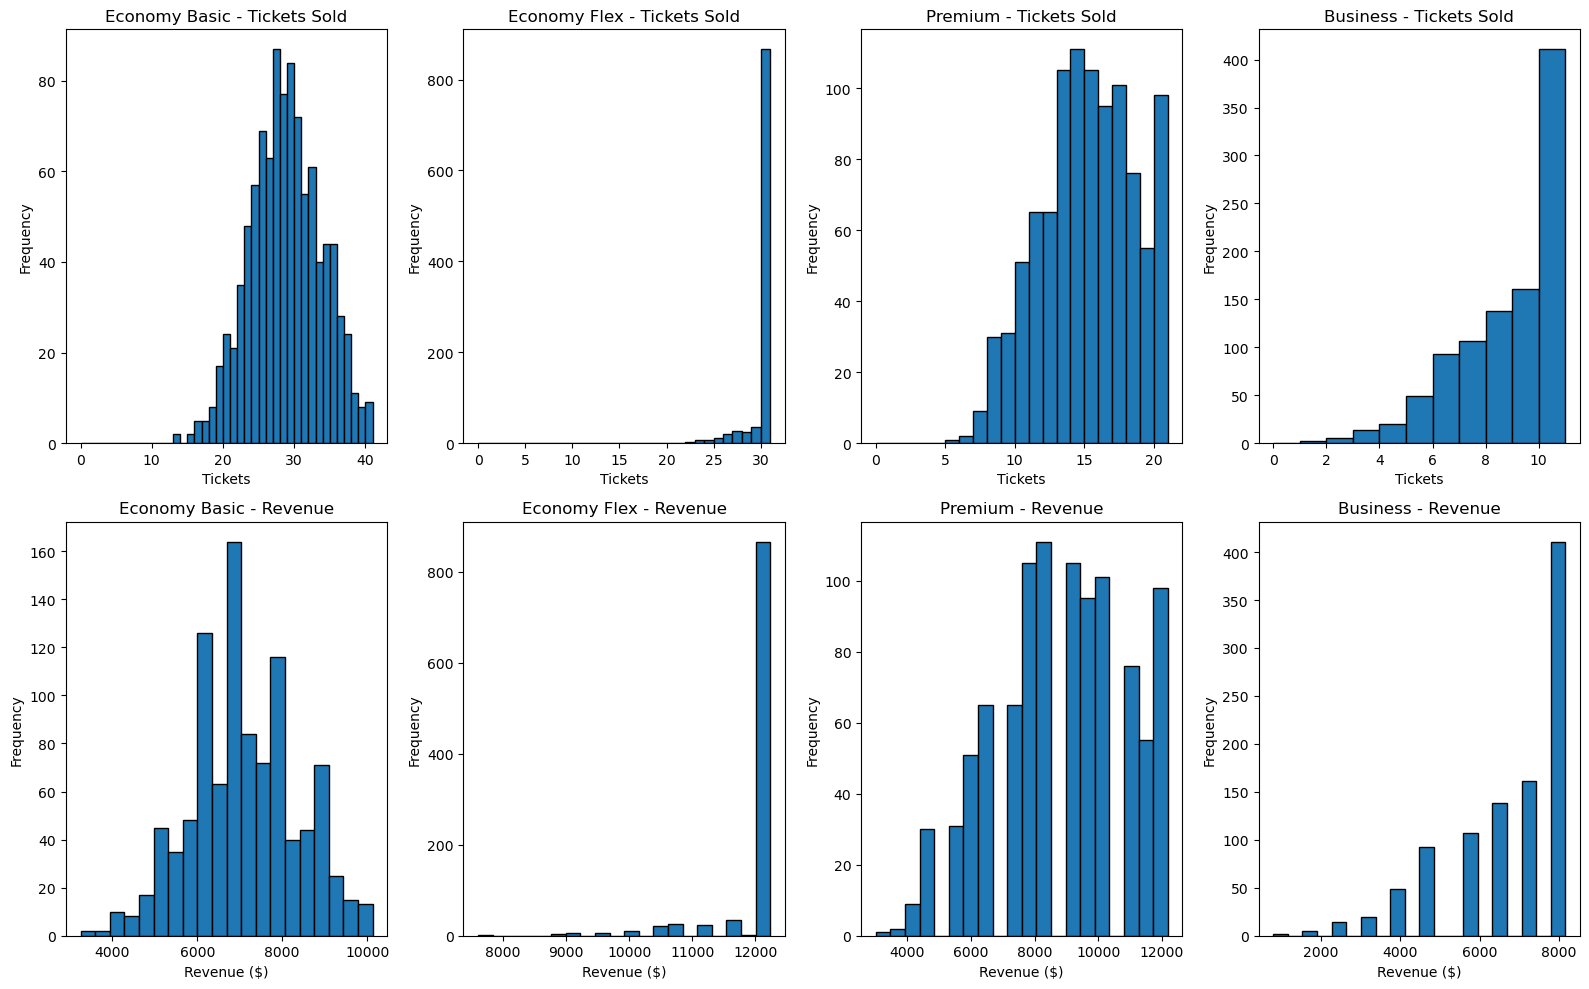

In [258]:
# --- Plot Histograms of Fare Bucket Revenues and Tickets Sold ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].hist(fare_sales_all_trials[i], bins=range(0, base_fare_buckets[i]["capacity"] + 2), edgecolor='black')
    axs[0, i].set_title(f"{label} - Tickets Sold")
    axs[0, i].set_xlabel("Tickets")
    axs[0, i].set_ylabel("Frequency")

    axs[1, i].hist(fare_revenues_all_trials[i], bins=20, edgecolor='black')
    axs[1, i].set_title(f"{label} - Revenue")
    axs[1, i].set_xlabel("Revenue ($)")
    axs[1, i].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("fare_bucket_histograms_3.png")
plt.show()

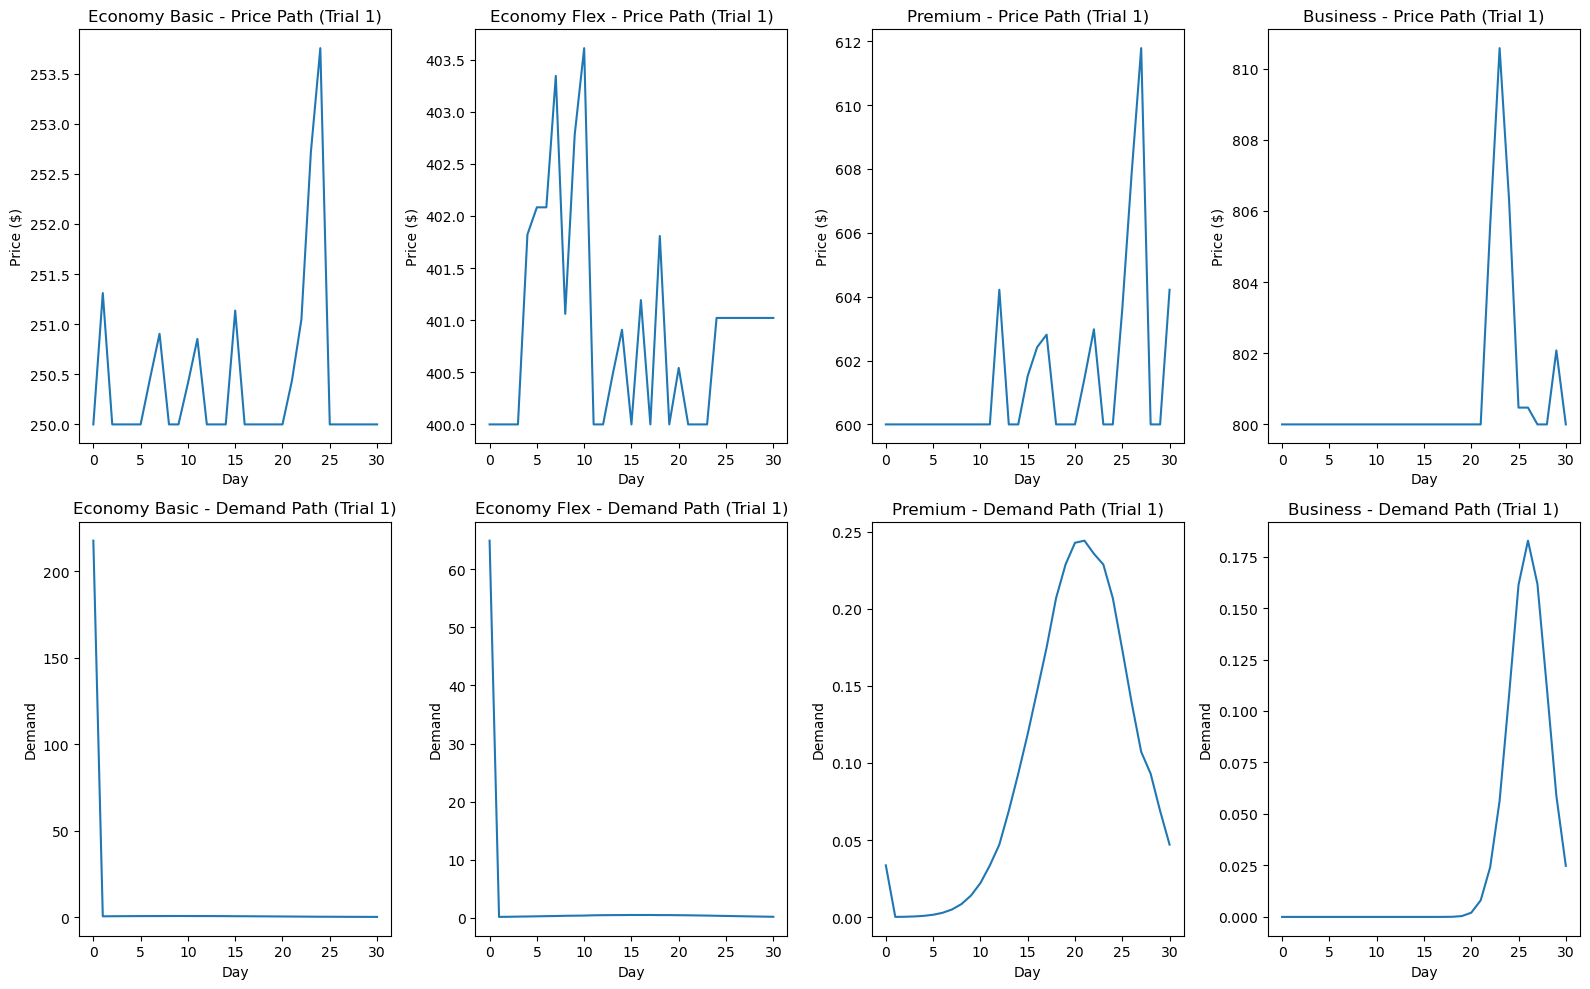

In [259]:
# --- Plot Price and Demand Paths for 100th Trial ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].plot(price_paths_example_trial[i])
    axs[0, i].set_title(f"{label} - Price Path (Trial 1)")
    axs[0, i].set_xlabel("Day")
    axs[0, i].set_ylabel("Price ($)")

    axs[1, i].plot(demand_paths_example_trial[i])
    axs[1, i].set_title(f"{label} - Demand Path (Trial 1)")
    axs[1, i].set_xlabel("Day")
    axs[1, i].set_ylabel("Demand")

plt.tight_layout()
plt.savefig("price_demand_paths_3.png")
plt.show()

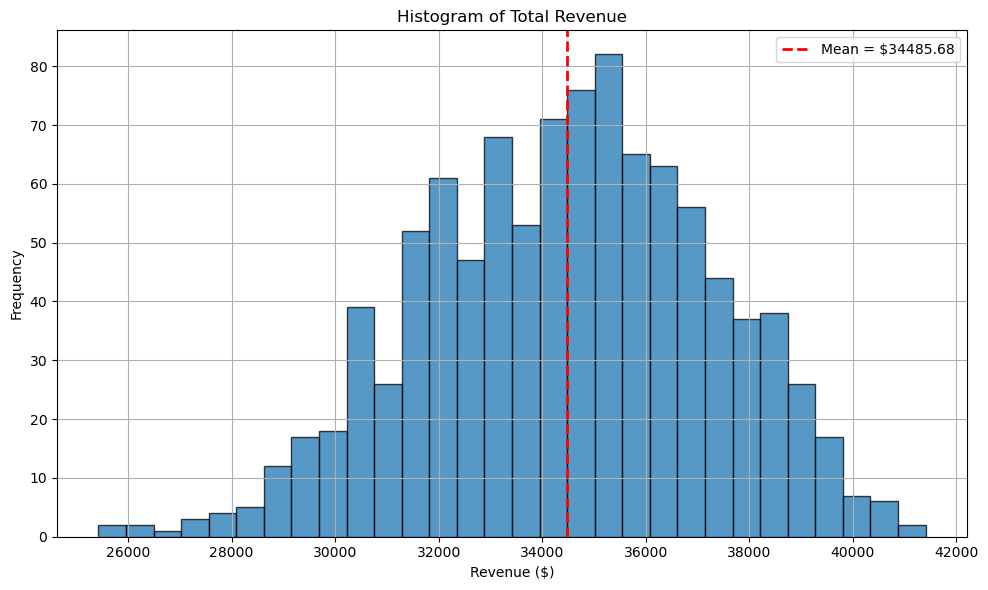

In [260]:
# Plotting revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(total_revenues, bins=30, edgecolor='black', alpha=0.75)
plt.axvline(mean_revenue, color='red', linestyle='dashed', linewidth=2, label=f"Mean = ${mean_revenue:.2f}")

plt.title("Histogram of Total Revenue")
plt.xlabel("Revenue ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("revenue_histogram_3.png")
plt.show()

This change kept average revenue essentially the same. An alternative method to generating more casual price shifts is through decreasing our alpha value in our repricing algorithm.

In [261]:
# Setting alpha value
alpha = 0.001

# Fare Bucket Setup
base_fare_buckets = [
    {
        "label": "Economy Basic",
        "base_price": 250,
        "capacity": 40,
        "elasticity": 0.025,
        "base_demand_curve": [bell(300, 8, 10, day) for day in range(days_to_departure)]  # Demand curve function
    },
    {
        "label": "Economy Flex",
        "base_price": 400,
        "capacity": 30,
        "elasticity": 0.015,
        "base_demand_curve": [bell(200, 15, 10, day) for day in range(days_to_departure)] # Demand curve function
    },
    {
        "label": "Premium",
        "base_price": 600,
        "capacity": 20,
        "elasticity": 0.01,
        "base_demand_curve": [bell(100, 20, 5, day) for day in range(days_to_departure)]
    },
    {
        "label": "Business",
        "base_price": 800,
        "capacity": 10,
        "elasticity": 0.005,
        "base_demand_curve": [bell(10, 25, 2, day) for day in range(days_to_departure)]  # Demand curve function
    }
]

bucket_labels = [b["label"] for b in base_fare_buckets]
num_buckets = len(base_fare_buckets)

# --- Trackers ---
total_revenues = []
fare_sales_all_trials = [[] for _ in base_fare_buckets]
fare_revenues_all_trials = [[] for _ in base_fare_buckets]
price_paths_example_trial = [[] for _ in base_fare_buckets]  # for 1st trial
demand_paths_example_trial = [[] for _ in base_fare_buckets]

In [262]:
# --- Run Monte Carlo ---
for t in range(num_trials):
    run_simulation(track_prices=(t == 0))  # only track price path for 1st trial

# --- Summary Statistics ---
mean_revenue = np.mean(total_revenues)
median_revenue = np.median(total_revenues)
std_revenue = np.std(total_revenues)

print("=== Revenue Summary ===")
print(f"Mean Revenue: ${mean_revenue:.2f}")
print(f"Median Revenue: ${median_revenue:.2f}")
print(f"Std Dev Revenue: ${std_revenue:.2f}\n")

print("=== Fare Bucket Summary ===")
for i, label in enumerate(bucket_labels):
    mean_sold = np.mean(fare_sales_all_trials[i])
    mean_rev = np.mean(fare_revenues_all_trials[i])
    print(f"{label}: Avg Tickets Sold = {mean_sold:.2f}, Avg Revenue = ${mean_rev:.2f}")

/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_15201/1190322460.py:52: RuntimeWarning: divide by zero encountered in log
  bucket["price"] = max(bucket["base_price"], bucket["price"] * (1 - alpha * (1 - np.log(pressure))))


=== Revenue Summary ===
Mean Revenue: $34394.07
Median Revenue: $34710.53
Std Dev Revenue: $3052.00

=== Fare Bucket Summary ===
Economy Basic: Avg Tickets Sold = 28.05, Avg Revenue = $7015.02
Economy Flex: Avg Tickets Sold = 29.54, Avg Revenue = $11821.43
Premium: Avg Tickets Sold = 14.87, Avg Revenue = $8925.50
Business: Avg Tickets Sold = 8.29, Avg Revenue = $6632.11


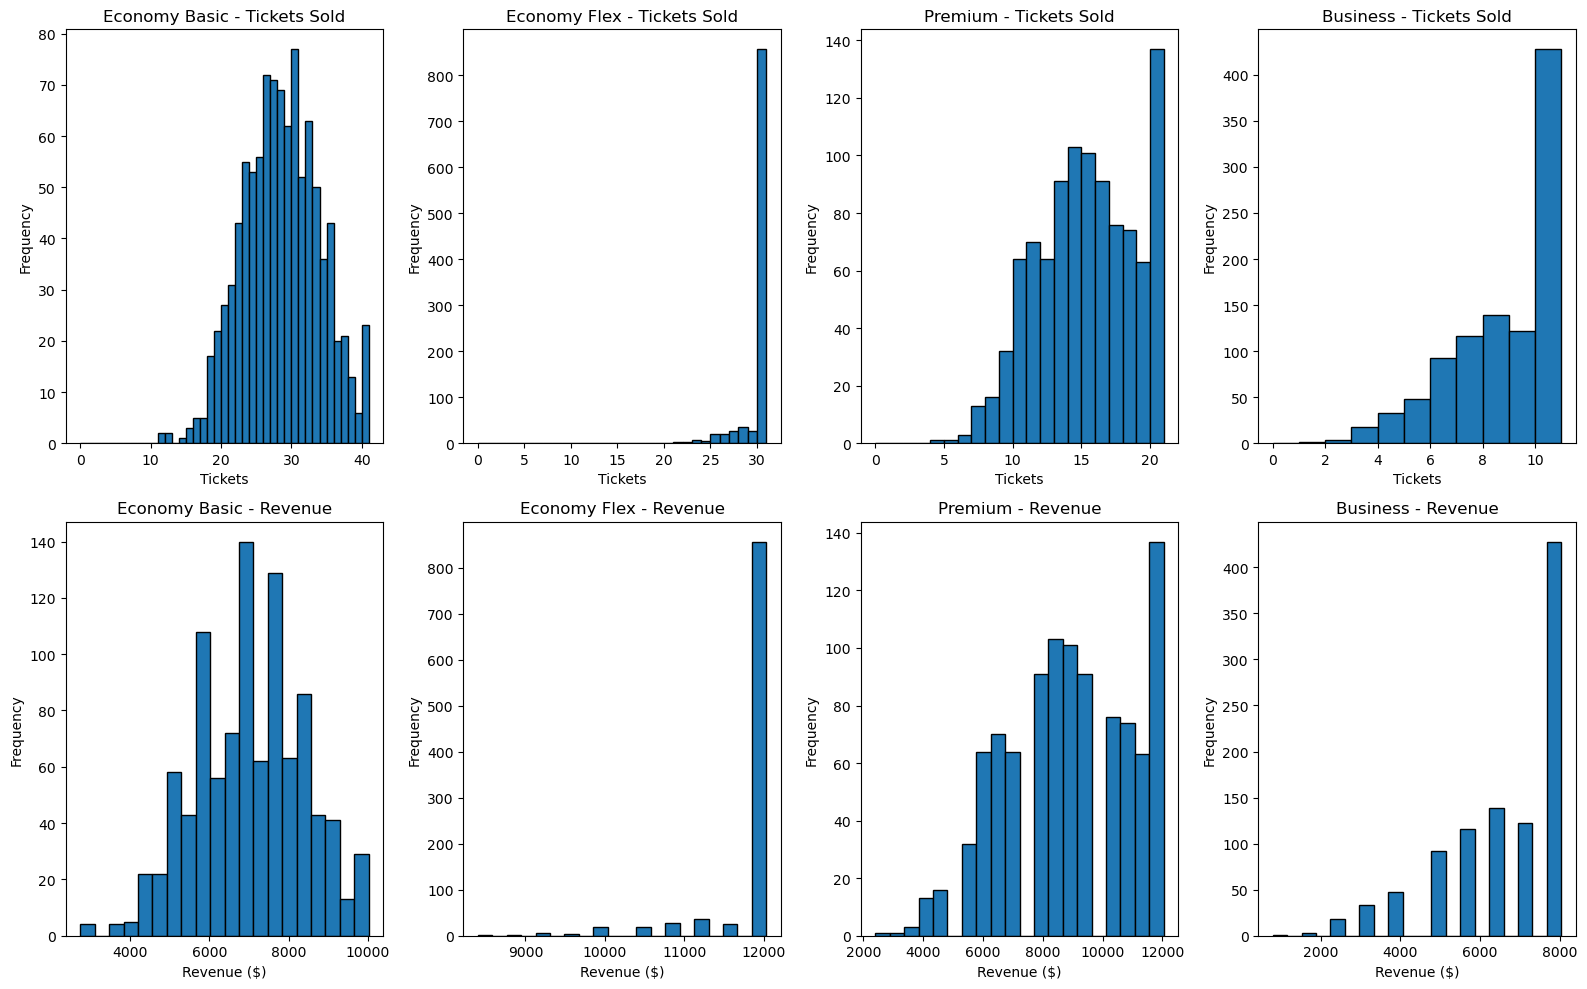

In [263]:
# --- Plot Histograms of Fare Bucket Revenues and Tickets Sold ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].hist(fare_sales_all_trials[i], bins=range(0, base_fare_buckets[i]["capacity"] + 2), edgecolor='black')
    axs[0, i].set_title(f"{label} - Tickets Sold")
    axs[0, i].set_xlabel("Tickets")
    axs[0, i].set_ylabel("Frequency")

    axs[1, i].hist(fare_revenues_all_trials[i], bins=20, edgecolor='black')
    axs[1, i].set_title(f"{label} - Revenue")
    axs[1, i].set_xlabel("Revenue ($)")
    axs[1, i].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("fare_bucket_histograms_4.png")
plt.show()

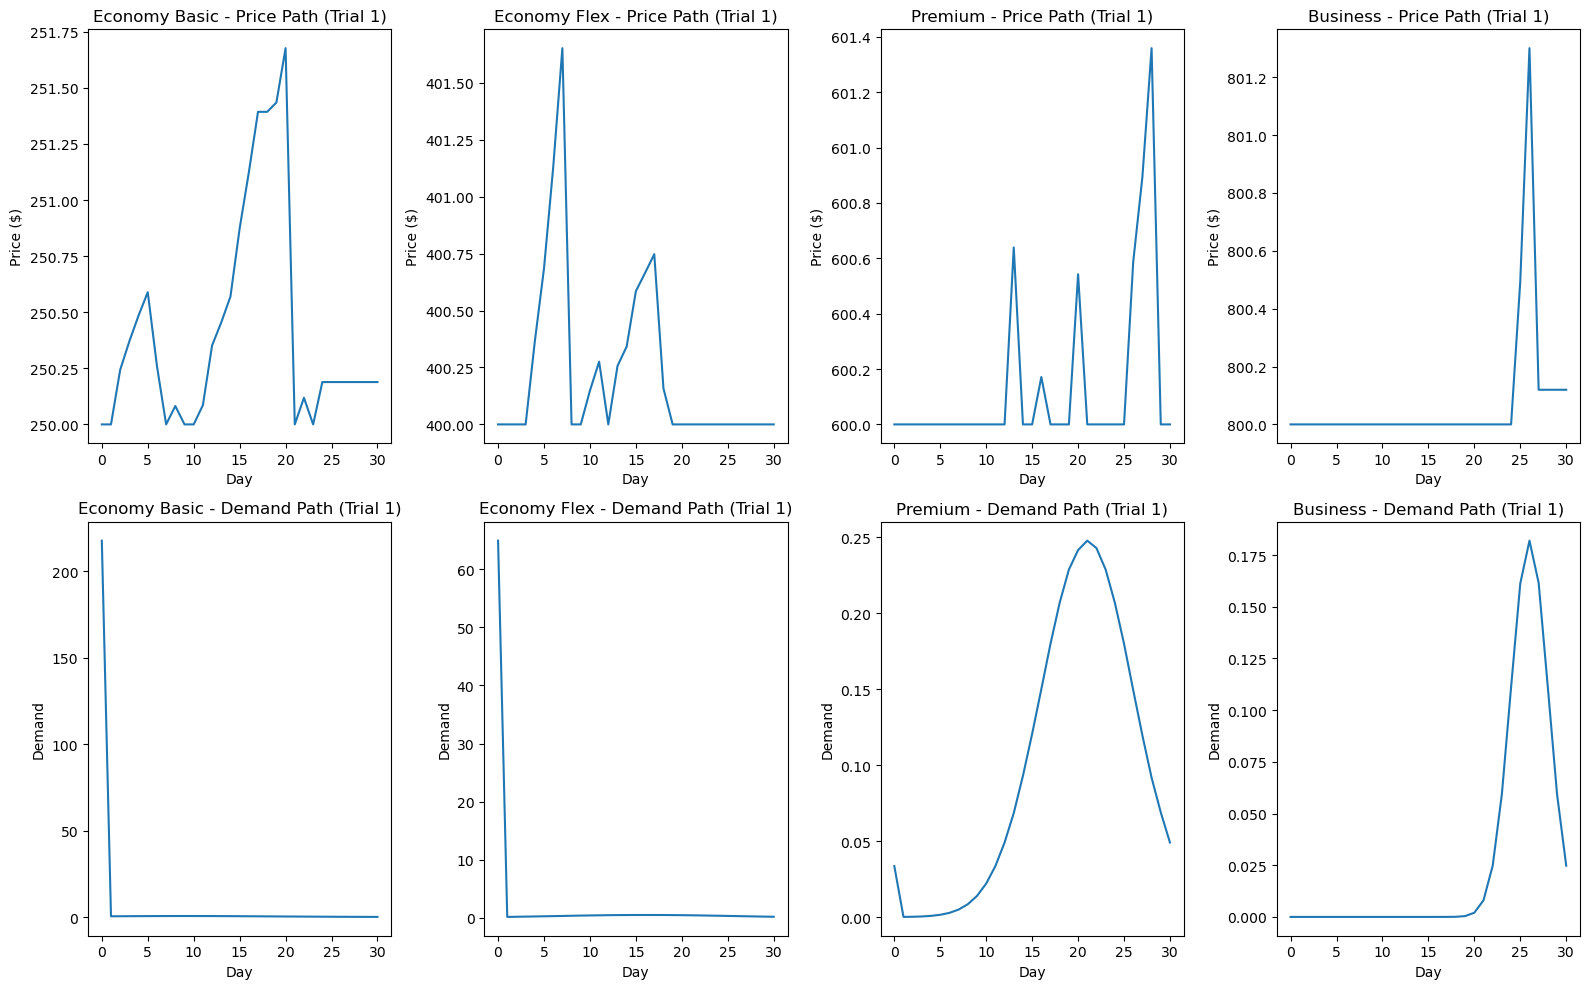

In [264]:
# --- Plot Price and Demand Paths for 100th Trial ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].plot(price_paths_example_trial[i])
    axs[0, i].set_title(f"{label} - Price Path (Trial 1)")
    axs[0, i].set_xlabel("Day")
    axs[0, i].set_ylabel("Price ($)")

    axs[1, i].plot(demand_paths_example_trial[i])
    axs[1, i].set_title(f"{label} - Demand Path (Trial 1)")
    axs[1, i].set_xlabel("Day")
    axs[1, i].set_ylabel("Demand")

plt.tight_layout()
plt.savefig("price_demand_paths_4.png")
plt.show()

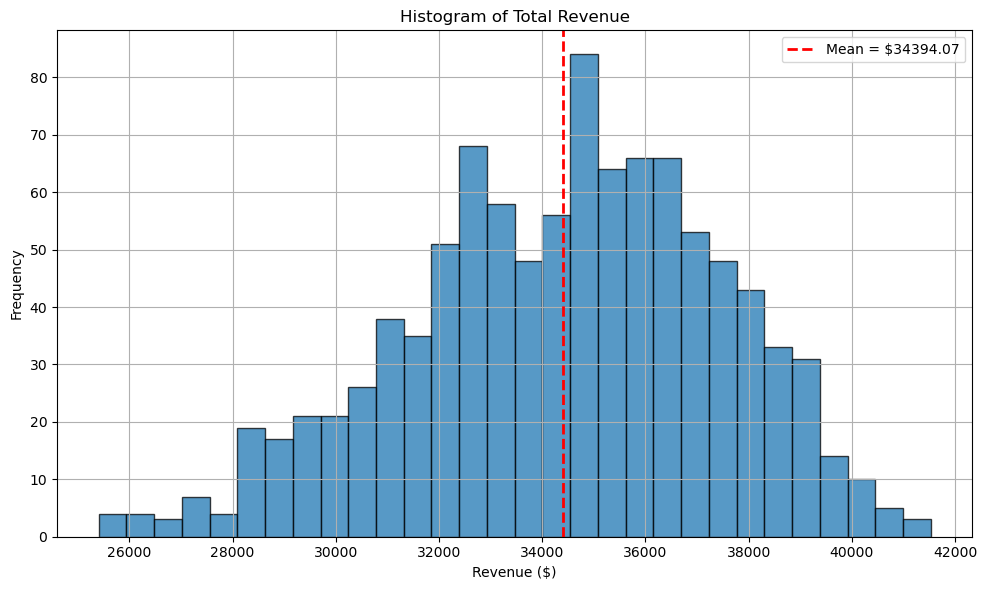

In [265]:
# Plotting revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(total_revenues, bins=30, edgecolor='black', alpha=0.75)
plt.axvline(mean_revenue, color='red', linestyle='dashed', linewidth=2, label=f"Mean = ${mean_revenue:.2f}")

plt.title("Histogram of Total Revenue")
plt.xlabel("Revenue ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("revenue_histogram_4.png")
plt.show()

Once again, this change did little to alter the average total revenue generated. However, for the lower two ticket types, we did see less aggressive price shifts, as we were hoping for.

Because of the nature of the base demand curves we assumed for each fare bucket, the clear next step would be to design repricing algorithms for each of the fare types separately. On top of this, looking at actual flight data might give us clearer insights into how the demand for each ticket type vary as we approach the departure date.

\documentclass\[12pt]{article}
\usepackage\[margin=1in]{geometry}
\usepackage{graphicx}
\usepackage{caption}
\usepackage{subcaption}
\usepackage{amsmath}
\usepackage{float}
\usepackage{titlesec}
\usepackage{hyperref}
\usepackage{booktabs}

\titleformat{\section}{\large\bfseries}{\thesection}{1em}{}

\title{\textbf{Dynamic Airline Fare Optimization Simulation}}
\author{Trevor Ruggeri}
\date{}

\begin{document}

\maketitle

\begin{abstract}
This report summarizes an iterative Monte Carlo simulation approach for dynamic airline fare pricing. The model incorporates exponential demand elasticity, multiple fare buckets, and adaptive pricing mechanisms. Over multiple trials, we refine our price adjustment method to improve realism and optimize revenue outcomes.
\end{abstract}

\section{1. Initial Simulation Results}

The simulation begins with four fare buckets, each with different prices, capacities, and elasticities. We simulated 100 customers per fare bucket per day, using an exponential demand model to determine the purchase probability.

In the initial simulation:
\begin{itemize}
\item All fare buckets sold out in nearly every trial.
\item Revenue was maximized, but this indicated that initial prices might be too low.
\item Prices spiked too much and too frequently, indicating the repricing algorithm was too aggressive.
\end{itemize}

\subsection\*{Tickets Sold and Fare Bucket Revenue}
\begin{figure}
\centering
\includegraphics\[width=0.75\linewidth]{fare\_bucket\_histograms\_1.png}
\caption{Initial ticket sales and revenue distributions across fare buckets.}
\end{figure}

\subsection\*{Price and Demand Paths (Initial Trial)}
\begin{figure}
\centering
\includegraphics\[width=0.75\linewidth]{price\_demand\_paths\_1.png}
\caption{Initial price and demand evolution (Trial 1). Prices did not respond significantly.}
\end{figure}

\subsection\*{Total Revenue}
The total revenue histogram showed strong performance, but the lack of price movement implied the model was underreacting to demand.

\begin{figure}
\centering
\includegraphics\[width=0.75\linewidth]{revenue\_histogram\_1.png}
\caption{Histogram of total revenue in initial simulation (red line: mean revenue).}
\end{figure}


\section{2. Improving Price Responsiveness}

We noticed that price changes occurred too slowly. To address this, we experimented with two methods:

\subsection\*{2.1 Shrinking the Price Adjustment Threshold}
We reduced the size of our target daily purchase rate range from $[0.75, 1.05]$ to $[0.98, 1.1]$.

\begin{figure}
\centering
\includegraphics\[width=0.75\linewidth]{price\_demand\_paths\_3.png}
\caption{Price and demand paths with lower threshold sensitivity. Price movement becomes more dynamic.}
\end{figure}

\subsection\*{2.2 Decreasing the Alpha Value}
To avoid extreme volatility, we reduced the \texttt{alpha} parameter in the price adjustment formula from $\alpha = 0.005$ $\alpha = 0.001$.

\begin{figure}
\centering
\includegraphics\[width=0.75\linewidth]{price\_demand\_paths\_4.png}
\caption{Paths with alpha reduced moderately. Price smoothness and realism improved.}
\end{figure}

\section{3. Final Simulation Results}

With the refined threshold and alpha, price movement was both meaningful and stable. Seats sold per bucket varied more naturally, and reallocation occurred more frequently.

\subsection\*{Ticket Sales and Revenue Histograms}
\begin{figure}
\centering
\includegraphics\[width=0.75\linewidth]{fare\_bucket\_histograms\_4.png}
\caption{Final ticket sales and revenue histograms per fare bucket.}
\end{figure}

\subsection\*{Final Revenue Distribution}
\begin{figure}
\centering
\includegraphics\[width=0.75\linewidth]{revenue\_histogram\_4.png}
\caption{Final revenue distribution across trials. Mean revenue increased slightly, yet showed more variance.}
\end{figure}

\section{4. Next Steps}
Future iterations of this model could include:
\begin{itemize}
\item Using \textbf{real booking data} to generate base daily demand curves for each fare bucket.
\item Assigning \textbf{different repricing logic per fare bucket} (e.g., faster reaction for Business class, slower for Economy).
\item Modeling \textbf{cancellation, rebooking, and overbooking} behavior.
\item Extending the simulation to a \textbf{multi-flight network}.
\end{itemize}

\end{document}


